# Large-scale Wilson-Cowan neural mass model

Consistent with previous studies (e.g., [Papadopoulos et al., 2020](https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1008144)), the coarse-grained form of the Wilson-Cowan equations ([Wilson & Cowan, 1972](https://doi.org/10.1016/s0006-3495(72)86068-5)) for the $i$-th brain region can be expressed as:

$$\tau_{E} \frac{dE_i(t)} {dt} = - E_i(t) + (1- E_i(t))f_{E}[w_{EE}E_i(t) - w_{IE}I_i(t)+G\sum_j w_{ji}E_{j}(t-d)+P_{E}] + \epsilon_{i}^{OU}(t)$$

$$\tau_{I} \frac{dI_i(t)} {dt} = - I_i(t) + (1- I_i(t))f_{I}(w_{EI}E_i(t)-w_{II}I_i(t)+P_{I}) + \epsilon_{i}^{OU}(t)$$

The variables $E_i(t)$ and $I_i(t)$ correspond to neuronal activity of the excitatory and inhibitory subpopulations of the $i$-th region (proportion of excitatory and inhibitory cells firing per unit time), $\tau_E$ and $\tau_I$ are the excitatory and inhibitory time constants, and $w_{EE}$, $w_{IE}$, $w_{EI}$ and $w_{II}$ are the connectivity coefficients between excitatory and inhibitory subpopulations representing the average number of excitatory and inhibitory synapses per cell (synaptic weights). The non-linear response functions $ƒ_E$ and $ƒ_I$ for excitatory and inhibitory subpopulations are defined as:
                       
$$f_E(x) =\frac{c_E} {(1 + \exp(-a_E  (x - b_E))}$$
                   
$$f_I(x) =\frac{c_I} {(1 + \exp(-a_I  (x - b_E))}$$

where $a_E$ and $a_I$ are the slopes, $b_E$ and $b_I$ are the positions of the maximum slope, $c_E$ and $c_I$ are the amplitudes of excitatory and inhibitory response functions.

The $G\sum_j w_{ji}E_{j}(t-d)$ term represents interactions of the $i$-th region with the rest of the network, $G$ is the global coupling parameter, $w_{ji}$ is the synaptic weight from the $j$-th to $i$-th region, and $d$ is the signal transmission delay between brain regions. The signal transmission delay was d = 25 ms, which is a physiologically plausible value for humans as estimated by [Ringo et al. (1994)](https://psycnet.apa.org/doi/10.1093/cercor/4.4.331). Synaptic weights ($w_{ji}$) were changed according to stimulus onsets.

The $P_E$ and $P_I$ terms are constant, background drive for excitatory and inhibitory subpopulations. The $\epsilon_{i}^{OU}$ term is the background noise modelled as an Ornstein-Uhlenbeck process with zero mean ([Uhlenbeck & Ornstein, 1930](https://doi.org/10.1103/PhysRev.36.823); [Cakan et al., 2021](https://doi.org/10.1007/s12559-021-09931-9), [2022](https://doi.org/10.3389/fncom.2021.800101)):

$$\frac{d\epsilon_{i}^{OU}(t)} {dt} = \frac{-OU_i(t)} {\tau_{OU}} + \sigma_{OU}*\epsilon_i(t)$$

where $\tau_{OU}$ is the time scale, $\sigma_{OU}$ is the standard deviation of the process, and $\epsilon_i$ is the white Gaussian noise.

Synaptic activity can be calculated as the sum of all inputs to the excitatory and inhibitory subpopulations ([Tagamets & Horwitz, 1998](https://doi.org/10.1093/cercor/8.4.310); [Kim & Horwitz, 2007](https://doi.org/10.1016/j.mri.2007.10.011); [Ulloa & Horwitz, 2016](https://doi.org/10.3389/fninf.2016.00032)):

$$SA_i(t) = w_{EE}E_i(t) + w_{EI}E_i(t) + w_{II}I_i(t) + w_{IE}I_i(t) + \sum_j w_{ji}E_j(t)$$

Synaptic activity $SA_i(t)$ was considered as a proxy for local field potential (LFP) and used as input to the Balloon-Windkessel model.

Numerical integration of the system of ordinary differential equations was performed using the Euler-Maruyama method with a time step of dt = 0.1 ms, implemented in the neurolib software (https://github.com/neurolib-dev/neurolib). Neurolib is a Python library that provides a computationally efficient framework for whole-brain resting-state functional connectivity (RSFC) simulations ([Cakan et al., 2021](https://doi.org/10.1007/s12559-021-09931-9)). In the current study, we modified the neurolib software to perform task-modulated functional connectivity (TMFC) simulations for a given task design and temporal resolution.



In [1]:
import matplotlib
import os
import sys
sys.path.append('..')
from er_simulator.wc_model import WCTaskSim
from er_simulator.functions import resample_signal
from er_simulator.synaptic_weights_matrices import normalize, generate_synaptic_weights_matrices
from er_simulator.read_utils import generate_sw_matrices_from_mat
from er_simulator.load_wc_params import load_wc_params
from er_simulator import functions
from er_simulator.boldIntegration import BWBoldModel
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy import signal, stats, io

matplotlib.rcParams['font.family'] = 'Avenir'
matplotlib.rcParams['font.size'] = 10
plt.rcParams['image.cmap'] = 'plasma'
np.set_printoptions(suppress=True)
%load_ext autoreload
%autoreload 2

## Setting up WC model parameters 

All fixed parameters of the Wilson-Cowan model were selected as in [Papadopoulos et al., 2020](https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1008144): 

<img src = "illustrations/WC_parameters.PNG" width = 800>

Three tuning parameters ($G$, $P_E$, $\tau_{OU}$) were determined based on the maximum similarity between the ground-truth synaptic weight matrix and the task-modulated functional connectivity (TMFC) matrix estimated using the direct correlation difference (CorrDiff) approach for block design time series without scanner measurement error. Similarity between matrices was assessed using Pearson’s r correlation.



In [2]:
#Notation and typical values for wc parameters

wc_params = {'exc_ext': 0.758, # excitatory background drive
             'K_gl': 2.63, # global coupling parameter
             'sigma_ou': 0.0035, # std of the Ornstein-Uhlenbeck noise
             'inh_ext': 0, # inhibitory background drive
             'tau_ou': 5, # [ms] timescale of the Ornstein-Uhlenbeck noise
             'a_exc': 1.5, # slope of excitatory response function
             'a_inh': 1.5, # slope of inhibitory response function
             'c_excexc': 16, # E-to-E synaptic weight
             'c_excinh': 15, # E-to-I synaptic weight
             'c_inhexc': 12, # I-to-E synaptic weight
             'c_inhinh': 3, # I-to-I synaptic weight
             'mu_exc': 3,  # position of maximum slope of excitatory response function
             'mu_inh': 3,  # Position of maximum slope of inhibitory response function
             'tau_exc': 2.5, # excitatory time constant
             'tau_inh': 3.75, # inhibitory time constant
             'signalV': 10 # signal transmission speed between areas [m/s]
            }


## Download task design info 

If **SMALL = False**, a full simulation will be performed (using all stimulus onset times from task design *.mat file).

If **SMALL = True**, short simulation will be performed for tesing purposes (using several first two stimulus onset times).

In [3]:
SMALL = True
mat_path = '../data/02_EVENT_[2s_TR]_[1s_DUR]_[6s_ISI]_[100_TRIALS].mat'
input_data = io.loadmat(mat_path)
if SMALL:
    small_input_data = input_data.copy()
    small_input_data['onsets'][0,0] = input_data['onsets'][0,0][:6]
    small_input_data['onsets'][0,1] = input_data['onsets'][0,1][:6]
    small_mat_path = os.path.join(os.path.dirname(mat_path),'small_'+os.path.basename(mat_path))
    io.savemat(small_mat_path, small_input_data)
    mat_path = small_mat_path
print(f"Task design file {os.path.basename(mat_path)} will be used for simulation")    

Task design file small_02_EVENT_[2s_TR]_[1s_DUR]_[6s_ISI]_[100_TRIALS].mat will be used for simulation


In [4]:
# all parameters will be download from yaml config file, check config before
wc_sim = WCTaskSim.from_config(config_file="../usage_examples/config_02_EVENT.yaml")
print(wc_sim.wc_params.keys())
print(wc_sim.bold_params.keys())

dict_keys(['dt', 'exc_ext', 'K_gl', 'inh_ext', 'a_exc', 'a_inh', 'c_excexc', 'c_excinh', 'c_inhexc', 'c_inhinh', 'mu_exc', 'mu_inh', 'tau_exc', 'tau_inh', 'tau_ou', 'sigma_ou', 'exc_ou_mean', 'inh_ou_mean', 'signalV', 'seed', 'exc_ou', 'inh_ou', 'exc_ext_baseline', 'inh_ext_baseline', 'exc_init', 'inh_init', 'lengthMat', 'Cmat'])
dict_keys(['k', 'gamma', 'tau', 'alpha', 'rho', 'fix', 'normalize_constant'])


## Generation of synaptic weight matrices

The construction of the synaptic weight matrices involved three steps.

First, we drew synaptic weights for each subject from a Gaussian distribution with a mean of one and a standard deviation of *SIGMA = 0.1*. 

Then, we multiplied the synaptic weights within and between functional modules by weighting factors that determined the network structure:

<img src = "illustrations/weighting_factors_for_synaptic_matrices.PNG" width = 800>

Weighting factors are specified in task design .mat files (*rest_matrix* and *task_matrices* structures).

Finally, we normalised the synaptic weights so that all inputs to each region summed to one, following previous simulation studies ([Cole et al., 2019](https://doi.org/10.1016/j.neuroimage.2018.12.054), [Papadopoulos et al., 2020](https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1008144)).

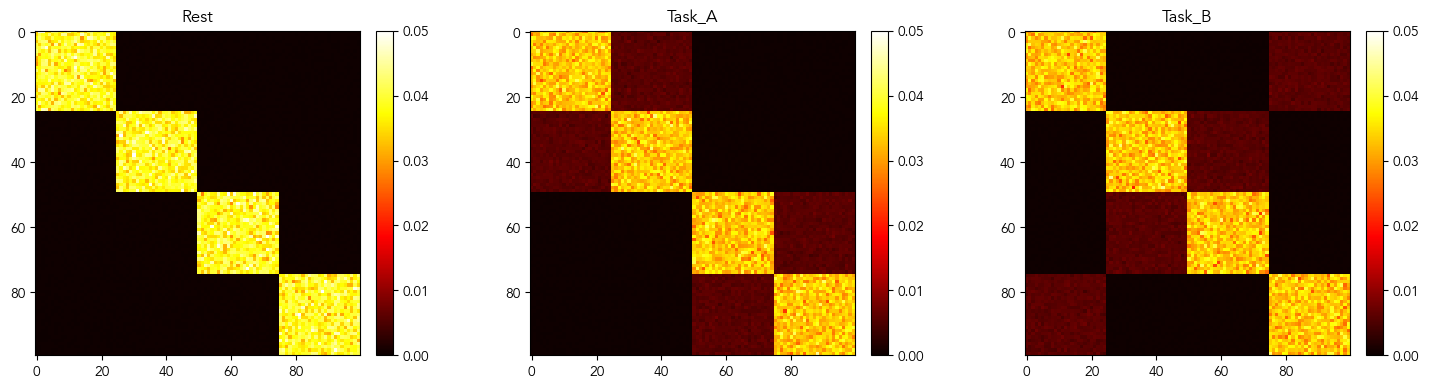

In [5]:
#Matrix were generated during model initialization, see parameters in config

#generate matrices using weighting factors, which we specified in "task_matrices" and "rest_matrices" sturctures of the task design .mat file
C_rest, C_task_dict = wc_sim.C_rest, wc_sim.C_task_dict
C_task_list = list(C_task_dict.values())
C_list = [C_rest]+C_task_list
title_list =['Rest']+ list(C_task_dict.keys())
fig, axs = plt.subplots(1, 3, figsize = (15,4))

#list of possible colormaps here: https://matplotlib.org/stable/tutorials/colors/colormaps.html
for i in [0,1,2]:
    im = axs[i].imshow(C_list[i], cmap='hot', vmin = 0, vmax=0.05); axs[i].set_title(title_list[i]);
    fig.colorbar(im, ax = axs[i], fraction=0.046, pad=0.04);
fig.tight_layout()

In [6]:
C_task_dict["Rest"] = C_rest
io.savemat("../data/synaptic_weights.mat", C_task_dict)

## Balloon-Windkessel hemodynamic model

Simulated neuronal activity was converted to the BOLD signal using the Balloon-Windkessel hemodynamic model ([Friston et al., 2003](https://doi.org/10.1016/S1053-8119(03)00202-7)). 

We used the standard parameters taken from [Friston et al., 2003](https://doi.org/10.1016/S1053-8119(03)00202-7), which have previously been used in whole-brain RSFC simulation studies(e.g. [Deco et al., 2009](https://doi.org/10.1073/pnas.0901831106)):

<img src = "illustrations/BW_parameters.PNG" width = 800>

$$k1 = 7\rho$$
$$k2 = 2$$
$$k3 = 2\rho - 0.2$$

In [7]:
wc_sim.bold_params 

{'k': {'value': 0.65, 'variance': 0.015},
 'gamma': {'value': 0.41, 'variance': 0.008},
 'tau': {'value': 2.5, 'variance': 0.2272},
 'alpha': {'value': 0.32, 'variance': 0.006},
 'rho': {'value': 0.34, 'variance': 0.0096},
 'fix': False,
 'normalize_constant': 0.001}

## Simulation setting

Also in config we define the remaining simulation parameters (sym_parameters:):

 - :: output_type (default'syn_act') neural oscillation type used for BOLD signal computation, available 'exc' (only exctitatory subpopulations),'syn_act' (synaptic activity),'all'  
 - :: delay (int or np.array of ints) - delay parameter, fiber length [in mm] (delay = 250 mm and signalV = 10 m/s result in signal transmission delay d = 25 ms) 
 - :: rest_before (default 12)  - duration of the rest period before zero time moment (dummy scans) [in seconds]
 - :: rest_after (default 8) - duration of the rest period at the end of simulation [in seconds]
 - :: TR (default 2) - repetition time for BOLD signal downsampling [in seconds]
 - :: mTime (default 0.02) - neuronal activity sampling rate [in seconds]
 

In [8]:
wc_sim.output_type, wc_sim.max_delay, wc_sim.rest_before, wc_sim.TR, wc_sim.mTime

('syn_act', 250, 12, 2, 0.005)

In [9]:
wc_sim.bold_params['rho']

{'value': 0.34, 'variance': 0.0096}

In [10]:
%%time
wc_sim.generate_full_series(compute_bold=True)

CPU times: user 33.4 s, sys: 2.04 s, total: 35.4 s
Wall time: 34.3 s


## Co-activations

We independently simulated co-activations using box-car functions to evaluate their impact on spurious inflation of TMFC estimates.

Neuronal activity = Oscillations (WC model) + Co-activations (box-car functions)

In the input file we have parameters with additional local activation for each condition, two arrays with the dimension equal to NUM_MODULES.


In [11]:
dt=50e-3
t_coactiv, coactive, bold_coactiv = wc_sim.generate_coactivation_by_mat(mat_path, dt=dt, normalize_constant=1)
bold_coactiv_tr, t_coactiv_tr = resample_signal(t_coactiv, bold_coactiv, dt, wc_sim.TR)

Local activation:  [[array([[1, 0, 1, 0]], dtype=uint8) array([[0, 1, 0, 1]], dtype=uint8)]]


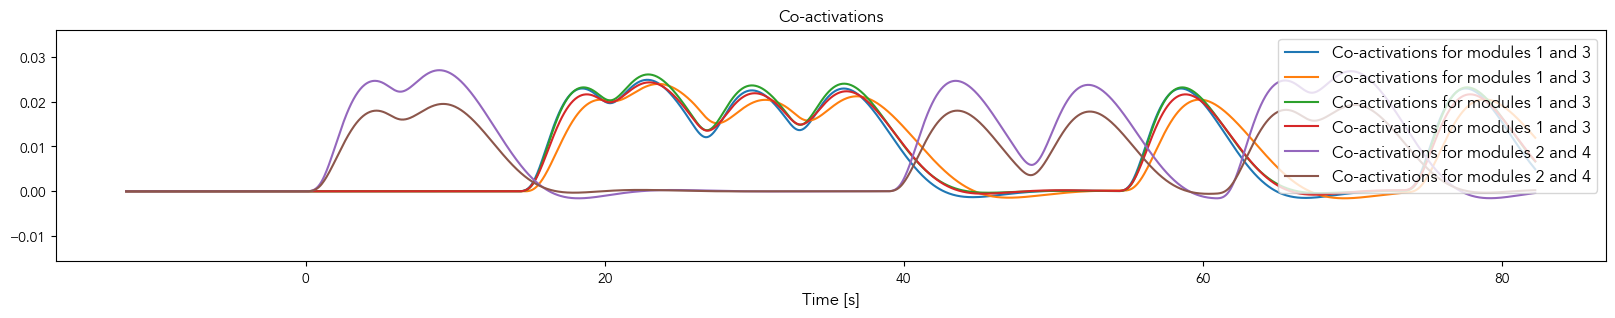

In [12]:
print("Local activation: ",input_data["activations"])
plt.figure(figsize=(20, 3))
plt.plot(t_coactiv, bold_coactiv[:4,:].T, label = 'Co-activations for modules 1 and 3');
plt.plot(t_coactiv, bold_coactiv[26:28,:].T, label = 'Co-activations for modules 2 and 4');

plt.ylim(10*np.min(bold_coactiv[1,:]), 1.5*np.max(bold_coactiv[1,:]))
plt.xlabel('Time [s]', fontsize = 12)
plt.legend(fontsize = 12)
plt.title('Co-activations', fontsize = 12);

## Results
## Power spectrum

/Users/irinaknyazeva/Yandex.Disk.localized/Projects/BrainIHBProjects/BrainActivitySimulations/TMFC_simulator/venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:600: UserWarning: nperseg = 1000 is greater than input length  = 48, using nperseg = 48
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,


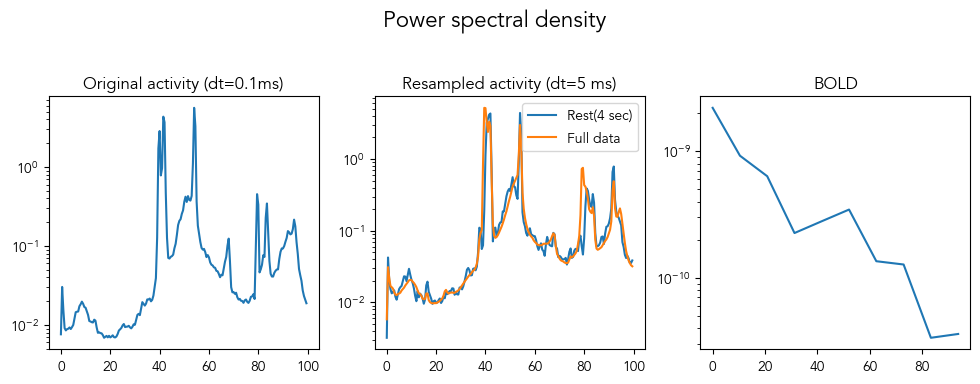

In [13]:
t, excs, inhs, exc_ou, inh_ou = wc_sim._generate_full_single_chunk(C_rest, 4000, update_inits=False)
syn_act = wc_sim.generate_neuronal_oscill(excs, inhs, C_rest)
maxfr = 100
windowsize = 2;
fig, axs = plt.subplots(1, 3, figsize = (10,4))
f1, Pxx_Welsh1 =  functions.getMeanPowerSpectrum(syn_act,0.1, spectrum_windowsize=windowsize, maxfr=maxfr)
axs[0].semilogy(f1,  Pxx_Welsh1); axs[0].set_title('Original activity (dt=0.1ms)', fontsize=12);
f, Pxx_Welsh =  functions.getMeanPowerSpectrum(wc_sim.output["syn_act"][:,-400:],5, spectrum_windowsize=windowsize, maxfr=maxfr)
axs[1].semilogy(f,  Pxx_Welsh, label="Rest(4 sec)"); axs[1].set_title('Resampled activity (dt=5 ms)', fontsize=12);
fig.suptitle("Power spectral density", fontsize=16); 
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
f, Pxx_Welsh =  functions.getMeanPowerSpectrum(wc_sim.output["syn_act"],5, spectrum_windowsize=windowsize, maxfr=maxfr)
axs[1].semilogy(f,  Pxx_Welsh, label="Full data");
axs[1].legend();
f2, Pxx_Welsh2 =  functions.getMeanPowerSpectrum(wc_sim.output["BOLD_TR"],2, spectrum_windowsize=windowsize, maxfr=maxfr)
axs[2].semilogy(f2,  Pxx_Welsh2); axs[2].set_title('BOLD', fontsize=12);

## Neuronal synchronization (not done)

Raw time series were downsampled from a temporal resolution of 0.1 ms to 5 ms and bandpass filtered it in a narrow carrier frequency range $[f_{carrier} – 2 Hz, f_{carrier} + 2 Hz]$, where $f_{carrier} = 40 Hz$. Next, we employed the Hilbert transform to obtain the instantaneous amplitudes and phases of the narrowband signal. The instantaneous amplitudes, or amplitude envelopes, were further cross-correlated with the simulated BOLD signals, while the instantaneous phases were utilised to estimate gamma-band neuronal synchronisation based on the phase-locking value (PLV) method ([Lachaux et al., 1999](https://doi.org/10.1002/(SICI)1097-0193(1999)8:4%3C194::AID-HBM4%3E3.0.CO;2-C)).

In [14]:
def compute_PLV(task_name, low_f=38, high_f=42):
    roi_idx1, roi_idx2 = np.triu_indices(wc_sim.num_regions, k=1)
    activity = wc_sim.get_task_block(task_name, 'mtime',  'syn_act',skip_time=0)
    nyquist = 1 / wc_sim.mTime / 2
    high_band = high_f / nyquist
    low_band = low_f / nyquist
    b1, a1 = signal.butter(4, [low_band, high_band], btype='bandpass')
    filtered_data = signal.filtfilt(b1, a1, activity)
    analytic_data = signal.hilbert(filtered_data)
    angles = np.angle(analytic_data)
    phase_diffs = np.zeros((len(roi_idx1), activity.shape[1]))
    for r in range(roi_idx1.shape[0]):
        phase_diffs[r, :] = angles[roi_idx1[r], :] - angles[roi_idx2[r], :]
    plv = abs(np.exp(1j * phase_diffs).mean(axis=1))
    plv_sym = np.eye(activity.shape[0])
    sym_synh = np.eye(activity.shape[0])
    sym_synh[roi_idx1, roi_idx2] = plv
    sym_synh = sym_synh+sym_synh.T
    return  sym_synh


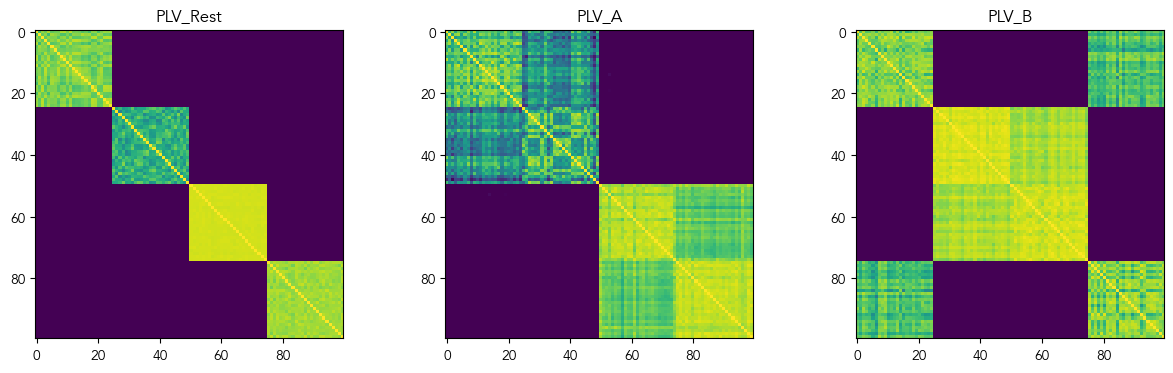

In [15]:
fig, axs = plt.subplots(1, 3, figsize = (15,4))

title_list = ['PLV_Rest','PLV_A', 'PLV_B']
task_names = ["Rest","Task_A", "Task_B"]
for i in [0,1,2]:
    im = axs[i].imshow(compute_PLV(task_names[i]), cmap='viridis', vmin = 0.7, vmax=1);
    axs[i].set_title(title_list[i]);
    

## Gamma-band envelope and BOLD-signal  (not done)

Compute cross-correlation between gamma-band envelope and BOLD-signal

In [16]:
def normalize(time_arr):
    if time_arr.ndim == 1:
        time_arr = time_arr.reshape(1, -1)
    mean_ = np.mean(time_arr, axis=1).reshape(-1, 1)
    std_ = np.std(time_arr, axis=1).reshape(-1, 1)
    return (time_arr - mean_) / std_
def compute_envelope(time_arr, srate, low_f=38, high_f=42):
    nyquist = 1 / srate / 2
    high_band = high_f / nyquist
    low_band = low_f / nyquist
    b1, a1 = signal.butter(4, [low_band, high_band], btype='bandpass')
    emg_filtered = signal.filtfilt(b1, a1, time_arr)
    hilbert_envelope = np.abs(signal.hilbert(emg_filtered))
    return hilbert_envelope
def plot_envelope_with_bold(time_arr,
                            node_id,
                            BOLD_TR,
                            srate,
                            TR,
                            plot_first=100,
                            drop_first_sec=7,
                            shift_sec=6,
                            low_f=38, 
                            high_f=42):

    nyquist = 1 / srate / 2
    high_band = high_f / nyquist
    low_band = low_f / nyquist
    b1, a1 = signal.butter(4, [low_band, high_band], btype='bandpass')
    emg_filtered = signal.filtfilt(b1, a1, time_arr[node_id])
    hilbert_envelope = np.abs(signal.hilbert(emg_filtered))
    plot_first_dt = int(plot_first / srate)
    drop_first_sec_TR = int(drop_first_sec / TR)
    drop_first_sec_dt = int(drop_first_sec / srate)
    step = int(TR / srate)
    bold_scaled = normalize(BOLD_TR[node_id, drop_first_sec_TR:]).flatten()
    shift_list_sec = list(np.linspace(-3, 7, 41))
    rcoeff_list = []
    for shift in shift_list_sec:
        shift = int(shift / srate)
        env_scaled_shifted = normalize(hilbert_envelope[drop_first_sec_dt - shift::step]).flatten()
        sig_len = min(len(env_scaled_shifted), len(bold_scaled))
        rcoeff, p_val = stats.pearsonr(env_scaled_shifted[:sig_len], bold_scaled[:sig_len])
        rcoeff_list.append(rcoeff)
    shift = int(shift_sec / srate)
    env_scaled_shifted = normalize(hilbert_envelope[drop_first_sec_dt - shift::step]).flatten()
    sig_len = min(len(env_scaled_shifted), len(bold_scaled))
    rcoeff, p_val = stats.pearsonr(env_scaled_shifted[:sig_len], bold_scaled[:sig_len])
    time = np.arange(sig_len) * TR

    fig = plt.figure(figsize=(12, 8))
    gs = fig.add_gridspec(3, 3)
    ax1 = fig.add_subplot(gs[0, :])
            # ax1.set_title('gs[0, :]')
    ax2 = fig.add_subplot(gs[1, :])
            # ax2.set_title('gs[1, :]')
    ax3 = fig.add_subplot(gs[-1, :-1])
    # ax3.set_title('gs[2, :-1]')
    ax4 = fig.add_subplot(gs[-1, -1])
    # ax4.set_title('gs[-1, -1]')
    ax1.plot(time_arr[node_id, :plot_first_dt]);
    ax1.set_title("Raw neuronal activity")
    ax2.plot(emg_filtered[:plot_first_dt]);
    ax2.set_title(f"Filtered neuronal with low:{low_f} high:{high_f}")
    ax2.plot(hilbert_envelope[:plot_first_dt]);
    ax3.plot(time, env_scaled_shifted[:sig_len], label="Envelope");
    ax3.plot(time, bold_scaled[:sig_len], 'orange', label="BOLD");
    ax3.legend();
    ax3.set_title(f"Shifted envelope with {shift_sec} s and BOLD, rcoeff {rcoeff:.2f}, p_val {(p_val):.3f} ")
    ax4.plot(shift_list_sec, rcoeff_list)
    ax4.set_title("Bold-Envelope correlation with different time lag")
    ax4.set_xlabel("Time lag (seconds) ")
    ax4.set_ylabel("Pearson r")
    fig.tight_layout()


In [17]:
#we can save it to output
hilbert_envelope = compute_envelope(wc_sim.output["syn_act"], wc_sim.mTime, low_f=38, high_f=42)

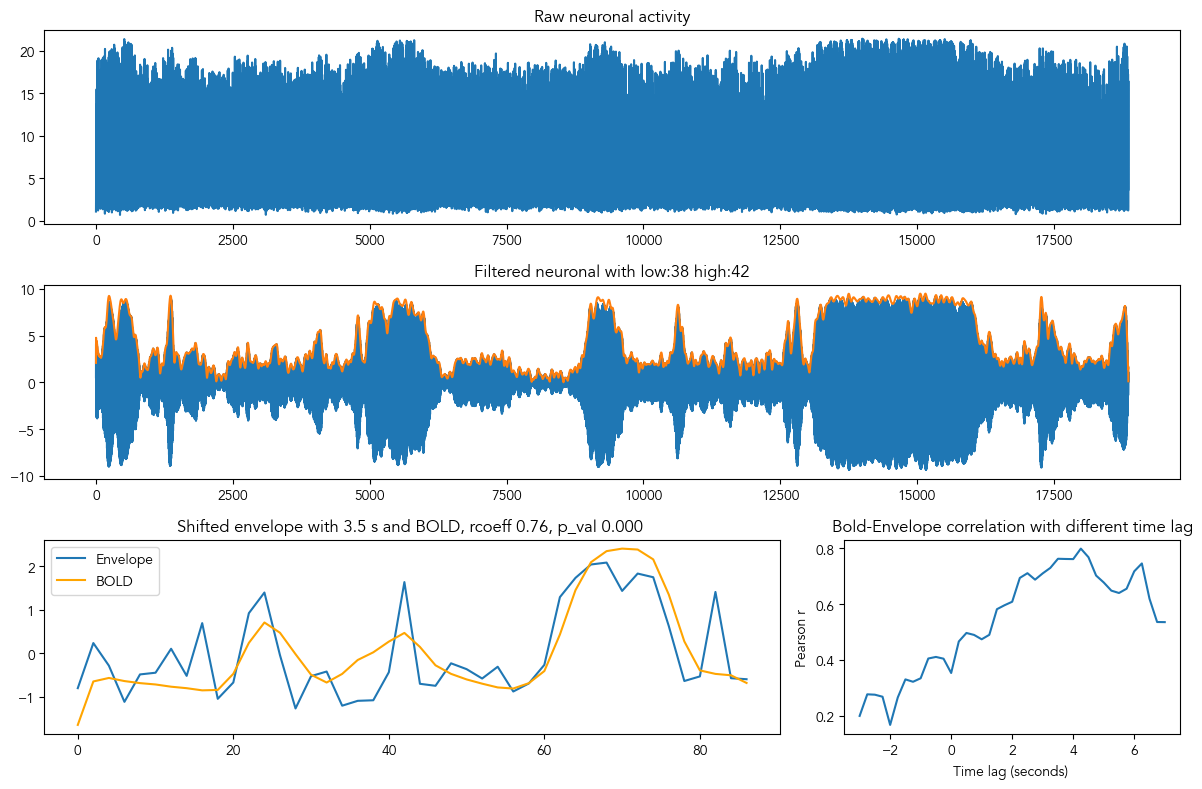

In [18]:
plot_envelope_with_bold(wc_sim.output["syn_act"],
                            2,
                            wc_sim.output["BOLD_TR"],
                            wc_sim.mTime,
                            wc_sim.TR,
                            plot_first=100,
                            drop_first_sec=8,
                            shift_sec=3.5)